In [1]:
import os

# 假设 notebook 和 Aerial_Landscapes 同级
base_path = "./Aerial_Landscapes"

# 获取类别：只保留文件夹，且排除隐藏文件（如 .DS_Store）
classes = sorted([
    d for d in os.listdir(base_path)
    if os.path.isdir(os.path.join(base_path, d)) and not d.startswith(".")
])

# 建立类别到索引的映射
class_to_idx = {cls: idx for idx, cls in enumerate(classes)}

print("类别数量:", len(classes))
print("类别示例:", classes[:5])


类别数量: 15
类别示例: ['Agriculture', 'Airport', 'Beach', 'City', 'Desert']


In [2]:
import cv2
import numpy as np
from sklearn.cluster import KMeans
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report, confusion_matrix
from sklearn.preprocessing import StandardScaler
from tqdm import tqdm
import matplotlib.pyplot as plt
import seaborn as sns

In [3]:
import random
def load_images_split(base_path):
    train_images, test_images = [], []
    train_labels, test_labels = [], []
    for cls_name in sorted(os.listdir(base_path)):
        cls_folder = os.path.join(base_path, cls_name)
        if os.path.isdir(cls_folder):
            all_imgs = sorted([os.path.join(cls_folder, f) for f in os.listdir(cls_folder) if f.endswith('.jpg') or f.endswith('.png')])
            random.shuffle(all_imgs)
            n_total = len(all_imgs)
            n_train = int(0.8 * n_total)
            for path in all_imgs[:n_train]:
                img = cv2.imread(path)
                train_images.append(img)
                train_labels.append(class_to_idx[cls_name])
            for path in all_imgs[n_train:]:
                img = cv2.imread(path)
                test_images.append(img)
                test_labels.append(class_to_idx[cls_name])
    return train_images, train_labels, test_images, test_labels

In [4]:
train_images, train_labels, test_images, test_labels = load_images_split(base_path)
print(f"训练图像数量: {len(train_images)}，测试图像数量: {len(test_images)}")

训练图像数量: 9600，测试图像数量: 2400


In [5]:
def extract_sift_gray(images):
    sift = cv2.SIFT_create()
    all_descriptors = []
    for i, img in enumerate(images):
        gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
        _, des = sift.detectAndCompute(gray, None)
        if des is not None:
            all_descriptors.append(des)
        else:
            print(f"图像 {i} 提取失败")
            all_descriptors.append(np.array([]))
    return all_descriptors

In [6]:
train_descriptors = extract_sift_gray(train_images)
print("训练集灰度 SIFT 特征提取完成")

图像 591 提取失败
图像 2565 提取失败
图像 2582 提取失败
图像 2584 提取失败
图像 2595 提取失败
图像 2603 提取失败
图像 2649 提取失败
图像 2665 提取失败
图像 2685 提取失败
图像 2714 提取失败
图像 2728 提取失败
图像 2768 提取失败
图像 2780 提取失败
图像 2782 提取失败
图像 2788 提取失败
图像 2790 提取失败
图像 2807 提取失败
图像 2818 提取失败
图像 2860 提取失败
图像 2897 提取失败
图像 2904 提取失败
图像 2914 提取失败
图像 2918 提取失败
图像 2936 提取失败
图像 2960 提取失败
图像 2963 提取失败
图像 2966 提取失败
图像 3012 提取失败
图像 3071 提取失败
图像 3129 提取失败
图像 3133 提取失败
图像 3138 提取失败
图像 3142 提取失败
图像 3151 提取失败
图像 3159 提取失败
图像 3166 提取失败
图像 3171 提取失败
图像 3173 提取失败
图像 3199 提取失败
图像 3484 提取失败
图像 3890 提取失败
图像 3925 提取失败
图像 3933 提取失败
图像 3938 提取失败
图像 3965 提取失败
图像 4014 提取失败
图像 4045 提取失败
图像 4070 提取失败
图像 4073 提取失败
图像 4077 提取失败
图像 4138 提取失败
图像 4157 提取失败
图像 4183 提取失败
图像 4272 提取失败
图像 4280 提取失败
图像 4363 提取失败
图像 4376 提取失败
图像 4406 提取失败
图像 4434 提取失败
图像 4473 提取失败
图像 5132 提取失败
图像 5198 提取失败
图像 5284 提取失败
图像 5342 提取失败
训练集灰度 SIFT 特征提取完成


In [7]:
NUM_CLUSTERS = 150
print("训练 BoW 词典...")
all_train_des = np.vstack([desc for desc in train_descriptors if desc.size > 0])
kmeans = KMeans(n_clusters=NUM_CLUSTERS, random_state=42, n_init='auto')
kmeans.fit(all_train_des)

训练 BoW 词典...


KMeans(n_clusters=150, random_state=42)

In [8]:
def build_bow_features(descriptor_list, kmeans):
    features = []
    for desc in descriptor_list:
        hist = np.zeros(NUM_CLUSTERS)
        if desc is not None and desc.size > 0:
            words = kmeans.predict(desc)
            for w in words:
                hist[w] += 1
        features.append(hist)
    return features

In [9]:
X_train = build_bow_features(train_descriptors, kmeans)
y_train = train_labels

In [10]:
print("提取测试集特征...")
test_descriptors = extract_sift_gray(test_images)
X_test = build_bow_features(test_descriptors, kmeans)
y_test = test_labels

提取测试集特征...


图像 93 提取失败
图像 655 提取失败
图像 668 提取失败
图像 676 提取失败
图像 716 提取失败
图像 720 提取失败
图像 726 提取失败
图像 742 提取失败
图像 746 提取失败
图像 776 提取失败
图像 794 提取失败
图像 981 提取失败
图像 986 提取失败
图像 1048 提取失败
图像 1059 提取失败


In [11]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

clf = SVC(kernel='linear', C=1.0, random_state=42)
clf.fit(X_train_scaled, y_train)
y_pred = clf.predict(X_test_scaled)

In [12]:
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred, average='macro', zero_division=0)
recall = recall_score(y_test, y_pred, average='macro', zero_division=0)
f1 = f1_score(y_test, y_pred, average='macro', zero_division=0)
report = classification_report(y_test, y_pred, target_names=classes)

print(f"准确率 (Accuracy): {accuracy:.4f}")
print(f"精确率 (Precision): {precision:.4f}")
print(f"召回率 (Recall): {recall:.4f}")
print(f"F1 分数 (F1-score): {f1:.4f}")
print("\n分类报告:\n", report)

准确率 (Accuracy): 0.6454
精确率 (Precision): 0.6510
召回率 (Recall): 0.6454
F1 分数 (F1-score): 0.6450

分类报告:
               precision    recall  f1-score   support

 Agriculture       0.56      0.65      0.60       160
     Airport       0.54      0.59      0.57       160
       Beach       0.66      0.71      0.68       160
        City       0.70      0.70      0.70       160
      Desert       0.49      0.73      0.59       160
      Forest       0.81      0.78      0.80       160
   Grassland       0.55      0.54      0.55       160
     Highway       0.56      0.52      0.54       160
        Lake       0.42      0.34      0.37       160
    Mountain       0.83      0.70      0.76       160
     Parking       0.87      0.91      0.89       160
        Port       0.78      0.71      0.74       160
     Railway       0.73      0.66      0.70       160
 Residential       0.84      0.76      0.80       160
       River       0.43      0.38      0.40       160

    accuracy                     

/tmp/ipykernel_1723/1269965210.py:7: UserWarning: Glyph 39044 (\N{CJK UNIFIED IDEOGRAPH-9884}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipykernel_1723/1269965210.py:7: UserWarning: Glyph 27979 (\N{CJK UNIFIED IDEOGRAPH-6D4B}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipykernel_1723/1269965210.py:7: UserWarning: Glyph 26631 (\N{CJK UNIFIED IDEOGRAPH-6807}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipykernel_1723/1269965210.py:7: UserWarning: Glyph 31614 (\N{CJK UNIFIED IDEOGRAPH-7B7E}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipykernel_1723/1269965210.py:7: UserWarning: Glyph 30495 (\N{CJK UNIFIED IDEOGRAPH-771F}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipykernel_1723/1269965210.py:7: UserWarning: Glyph 23454 (\N{CJK UNIFIED IDEOGRAPH-5B9E}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipykernel_1723/1269965210.py:7: UserWarning: Glyph 28151 (\N{CJK UNIFIED IDEOGRAPH-6DF7}) missi

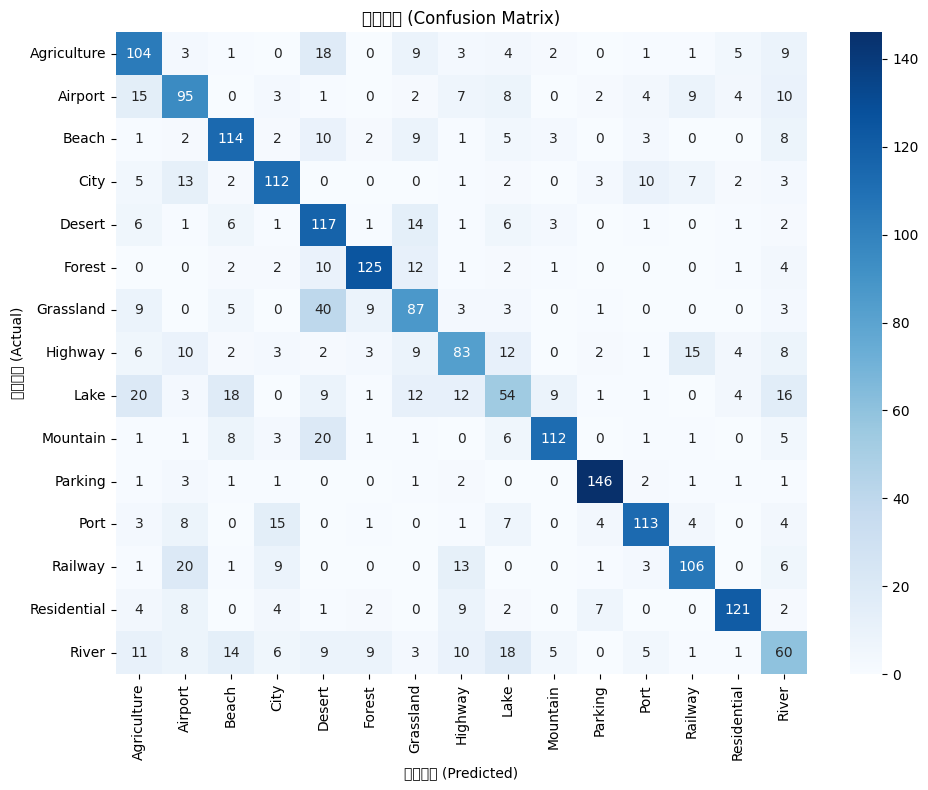

In [13]:
conf_mat = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(10, 8))
sns.heatmap(conf_mat, annot=True, fmt='d', xticklabels=classes, yticklabels=classes, cmap='Blues')
plt.title("混淆矩阵 (Confusion Matrix)")
plt.xlabel("预测标签 (Predicted)")
plt.ylabel("真实标签 (Actual)")
plt.tight_layout()
plt.show()

In [ ]:

def augment_image(img):
    if np.random.rand() > 0.5:
        img = cv2.flip(img, 1)
    angle = np.random.uniform(-15, 15)
    h, w = img.shape[:2]
    M = cv2.getRotationMatrix2D((w//2, h//2), angle, 1)
    img = cv2.warpAffine(img, M, (w, h))
    return img

def load_images_with_augmentation(base_path):
    train_images, test_images = [], []
    train_labels, test_labels = [], []
    for cls_name in sorted(os.listdir(base_path)):
        cls_folder = os.path.join(base_path, cls_name)
        if os.path.isdir(cls_folder):
            all_imgs = sorted([os.path.join(cls_folder, f) for f in os.listdir(cls_folder) if f.endswith('.jpg') or f.endswith('.png')])
            random.shuffle(all_imgs)
            n_total = len(all_imgs)
            n_train = int(0.8 * n_total)
            for path in all_imgs[:n_train]:
                img = cv2.imread(path)
                train_images.append(img)
                train_images.append(augment_image(img.copy()))
                train_labels.append(class_to_idx[cls_name])
                train_labels.append(class_to_idx[cls_name])
            for path in all_imgs[n_train:]:
                img = cv2.imread(path)
                test_images.append(img)
                test_labels.append(class_to_idx[cls_name])
    return train_images, train_labels, test_images, test_labels


In [ ]:

def add_gaussian_noise(img, mean=0, std=20):
    noise = np.random.normal(mean, std, img.shape).astype(np.uint8)
    return cv2.add(img, noise)

def apply_blur(img, ksize=(7,7)):
    return cv2.GaussianBlur(img, ksize, 0)

def add_occlusion(img, size=40):
    h, w, _ = img.shape
    x = np.random.randint(0, w - size)
    y = np.random.randint(0, h - size)
    img[y:y+size, x:x+size] = 0
    return img

def evaluate_robustness(test_images, test_labels, transform_func, label=""):
    transformed = [transform_func(img.copy()) for img in test_images]
    test_desc = extract_sift_gray(transformed)
    X_test = build_bow_features(test_desc, kmeans)
    y_pred = svm.predict(X_test)
    print(f"\n--- 鲁棒性测试：{label} ---")
    print(classification_report(test_labels, y_pred))

evaluate_robustness(test_images, test_labels, add_gaussian_noise, "高斯噪声")
evaluate_robustness(test_images, test_labels, apply_blur, "模糊")
evaluate_robustness(test_images, test_labels, add_occlusion, "遮挡")


In [ ]:

from sklearn.metrics import confusion_matrix
import seaborn as sns
from sklearn.manifold import TSNE

def plot_confusion_matrix(y_true, y_pred, class_names):
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(12,10))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.title('Confusion Matrix')
    plt.show()

plot_confusion_matrix(test_labels, svm.predict(X_test), classes)

def visualize_bow_features(X, y, title):
    tsne = TSNE(n_components=2, random_state=42)
    X_2d = tsne.fit_transform(X)
    plt.figure(figsize=(10, 8))
    scatter = plt.scatter(X_2d[:, 0], X_2d[:, 1], c=y, cmap='tab20', s=10)
    plt.legend(*scatter.legend_elements(), bbox_to_anchor=(1.05, 1), loc='upper left', title="Classes")
    plt.title(title)
    plt.show()

visualize_bow_features(X_train, y_train, "t-SNE of BoW Features (Train)")
